# Remote Sensing Assignment
## Ship Detection Based on the Paper "Optimal Target Detection Using One Channel SAR Complex Imagery: Application to Ship Detection"

#### Dimitrije Zdrale
#### Nikola Dobricic
#### Marija Brkic

**Reference:** A. Lopes, J. Bruniquel, F. Sery, J. . -C. Souyris and F. Adragna, "Optimal target detection using one channel SAR complex imagery: application to ship detection," IGARSS '98. Sensing and Managing the Environment. 1998 IEEE International Geoscience and Remote Sensing. Symposium Proceedings. (Cat. No.98CH36174), Seattle, WA, USA, 1998, pp. 813-815 vol.2, doi: 10.1109/IGARSS.1998.699592. keywords: {Object detection;Marine vehicles;Radiometry;Testing;Clutter;Speckle;Reflectivity;Light rail systems;Random variables;Application software},



In [123]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from pathlib import Path
from scipy.special import hyp2f1, beta as beta_func
from scipy.optimize import brentq
from scipy.ndimage import binary_closing, binary_opening

First we will extract .tiff files taken from the Copernicus Browser. SAR images were taken with Sentinel-1 with Interferometric Wide Swath (IW) mode, with both VV and VH polarization. However, only VH polarization will be used for ship detection because it provides better contrast between ships and sea clutter. While VV polarization gives stronger backscatter from metallic surfaces, VH (cross-polarized) is less affected by sea surface roughness and provides cleaner ship signatures with reduced sea clutter interference. All images are taken from the Gulf of Mexico.

In [2]:

extract_dir = "S1A_SAFE_extracted"
measurement_path = os.path.join(extract_dir, 
                                "S1A_IW_SLC__1SDV_20251115T002636_20251115T002703_061881_07BCC0_592D.SAFE", 
                                "measurement")

tiff_files = []
for root, dirs, files in os.walk(measurement_path):
    tiff_files.extend([os.path.join(root, f) for f in files if f.endswith('.tiff')])

print(f"Found {len(tiff_files)} TIFF files:")
for i, tiff in enumerate(tiff_files):
    filename = os.path.basename(tiff)
    print(f"  {i}: {filename}")

Found 6 TIFF files:
  0: s1a-iw1-slc-vh-20251115t002637-20251115t002702-061881-07bcc0-001.tiff
  1: s1a-iw1-slc-vv-20251115t002637-20251115t002702-061881-07bcc0-004.tiff
  2: s1a-iw2-slc-vh-20251115t002638-20251115t002703-061881-07bcc0-002.tiff
  3: s1a-iw2-slc-vv-20251115t002638-20251115t002703-061881-07bcc0-005.tiff
  4: s1a-iw3-slc-vh-20251115t002636-20251115t002701-061881-07bcc0-003.tiff
  5: s1a-iw3-slc-vv-20251115t002636-20251115t002701-061881-07bcc0-006.tiff


In [149]:
# Load one TIFF file (VH polarization)
selected_file = tiff_files[0] 
print(f"Loading: {os.path.basename(selected_file)}")

with rasterio.open(selected_file) as src:
    print(f"\nImage Info:")
    print(f"  Dimensions: {src.width} x {src.height}")
    print(f"  Data type: {src.dtypes[0]}")
    print(f"  Number of bands: {src.count}")
    print(f"  CRS: {src.crs}")
    

    complex_data = src.read(1)
    
print(f"\nData shape: {complex_data.shape}")
print(f"Data type: {complex_data.dtype}")


Loading: s1a-iw1-slc-vh-20251115t002637-20251115t002702-061881-07bcc0-001.tiff

Image Info:
  Dimensions: 21490 x 13428
  Data type: complex_int16
  Number of bands: 1
  CRS: None

Data shape: (13428, 21490)
Data type: complex64

Data shape: (13428, 21490)
Data type: complex64


Since the images are quite large and cover a large area, we needed to select regions of interest (ROI). To detect ships, we extracted parts of images where ships were present, focusing on areas with only water and ships. This has to be done manually for each ROI. We also tried to exclude the coast, since it has high radiometry that would disturb the algorithm, causing coastal areas to be falsely detected as ships.

This algorithm uses the likelihood ratio test and assumes that the target area (the area with the ship) will have larger mean power than the mean power of the background clutter, which exhibits speckle noise. 

In [150]:
# Full image is too big to work with so we will use only part of it
roi_size = 256
center_x = complex_data.shape[1] // 2
center_y = complex_data.shape[0] // 2

start_x = center_x + roi_size*2 + roi_size //2
start_y = center_y + roi_size*3

sar_roi = complex_data[start_y:start_y+roi_size, start_x:start_x+roi_size]


print(f"ROI shape: {sar_roi.shape}")
print(f"ROI dtype: {sar_roi.dtype}")

ROI shape: (256, 256)
ROI dtype: complex64


Now we implement the detection algorithm followed by morphological cleaning (erosion and dilation) to remove wrongly detected parts and connect all regions belonging to one ship. Every step is shown in the images below. Different target and window sizes were tested, as well as dilation and erosion windows, and the allowed probability of false alarm.

In [151]:

def image_intensity(img):
    intensity = np.abs(img)**2
    intensity_db = 10 * np.log10(intensity + 1e-10) 
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Linear scale
    axes[0].imshow(intensity, cmap='gray', vmin=np.percentile(intensity, 1), 
                vmax=np.percentile(intensity, 99))
    axes[0].set_title('SAR Intensity (Linear Scale)', fontsize=14)
    axes[0].axis('off')

    # dB scale
    axes[1].imshow(intensity_db, cmap='gray', vmin=np.percentile(intensity_db, 1), 
                vmax=np.percentile(intensity_db, 99))
    axes[1].set_title('SAR Intensity (dB Scale)', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    return intensity



def compute_threshold_lopes1998(N1, N2, P_FA):
    """
    
    Equation (6): P_FA = 1 - (1/B(N1,N2)) * (t^N1 / N1) * 2F1(N1, 1-N2; 1+N1; t)
    where t = N1*T / (N2 + N1*T)
    
    We solve for T such that the CDF equals (1 - P_FA).
    """
    
    def pfa_from_threshold(T):
        if T <= 0:
            return 1.0  # All pixels detected
        
        # Transform: t = N1*T / (N2 + N1*T)
        t = (N1 * T) / (N2 + N1 * T)
        
        if t >= 1.0:
            return 0.0  # No detections
        
        try:
            # Beta function B(N1, N2) = Γ(N1)Γ(N2) / Γ(N1+N2)
            B_val = beta_func(N1, N2)
            
            # Hypergeometric function 2F1(N1, 1-N2; 1+N1; t)
            hyp_val = hyp2f1(N1, 1 - N2, 1 + N1, t)
            
            cdf = (1.0 / B_val) * (t**N1 / N1) * hyp_val
            
            pfa_computed = 1.0 - cdf
            
            return pfa_computed
            
        except Exception as e:
            print(f"Warning: Numerical issue in hypergeometric function: {e}")
            return None
    
    def equation_to_solve(T):
        pfa_val = pfa_from_threshold(T)
        if pfa_val is None:
            return float('inf')
        return pfa_val - P_FA
    
    # Solve for threshold T
    try:
        # Search in reasonable range [0.1, 20]
        T_solution = brentq(equation_to_solve, 0.1, 20.0, maxiter=100) # Finds root
        return T_solution
        
    except ValueError as e:
        print(f"Warning: Root finding failed: {e}")
        print("Using empirical approximation instead.")
        # Fallback to empirical formula
        T_empirical = 1.5 - 0.5 * np.log10(P_FA)
        return max(1.5, min(T_empirical, 10.0))


def detection_algorithm(sar_image, N1, N2, P_FA):
    intensity = image_intensity(sar_image)
    
    T_computed = compute_threshold_lopes1998(N1**2, N2**2 - N1**2, P_FA)
    print(f"Computed detection threshold T: {T_computed:.4f}")
    padded_image = np.pad(intensity, N2, mode='constant', constant_values=0)
    binary_detection_map = np.zeros_like(padded_image, dtype=np.uint8)
    for i in range(N2, padded_image.shape[0] - N2):
        for j in range(N2, padded_image.shape[1] - N2):
            test_area = padded_image[i - N1:i + N1 + 1, j - N1:j + N1 + 1]
            test_mean = np.mean(test_area)
            local_mean = (np.sum(padded_image[i - N2:i + N2 + 1, j - N2:j + N2 + 1]) - 
                        np.sum(test_area)) / ( (2*N2 + 1)**2 - (2*N1 + 1)**2 )
            if local_mean == 0:
                binary_detection_map[i, j] = 0
            else:
                r = test_mean / local_mean
                if r > T_computed:
                    binary_detection_map[i, j] = 1
                else:
                    binary_detection_map[i, j] = 0
    # Remove padding to match original image size
    binary_detection_map = binary_detection_map[N2:-N2, N2:-N2]

    plt.figure(figsize=(8, 8))
    plt.imshow(binary_detection_map, cmap='gray')
    plt.title('Binary Detection Map Before Cleaning')
    plt.axis('off')
    plt.show()

    cleaned_map = binary_opening(binary_closing(binary_detection_map, structure=np.ones((20,20))), structure=np.ones((9,9)))
    plt.figure(figsize=(8, 8))
    plt.imshow(cleaned_map, cmap='gray')
    plt.title('Binary Detection Map After Cleaning')
    plt.axis('off')
    plt.show()

    
    masked_intensity = intensity.copy()
    masked_intensity[cleaned_map == 0] = np.nan 

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Original SAR image (linear scale)
    axes[0].imshow(intensity, cmap='gray', vmin=np.percentile(intensity, 1), 
                vmax=np.percentile(intensity, 99))
    axes[0].set_title('Original SAR Image (Linear)', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Binary mask
    axes[1].imshow(cleaned_map, cmap='gray')
    axes[1].set_title('Detection Mask', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Masked intensity (only detected regions) - linear scale
    axes[2].imshow(intensity, cmap='gray', vmin=np.percentile(intensity, 1), 
                vmax=np.percentile(intensity, 99))
    axes[2].imshow(masked_intensity, cmap='hot', vmin=np.percentile(intensity, 1), 
                vmax=np.percentile(intensity, 99))
    axes[2].set_title('Detected Ships Only', fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    return cleaned_map



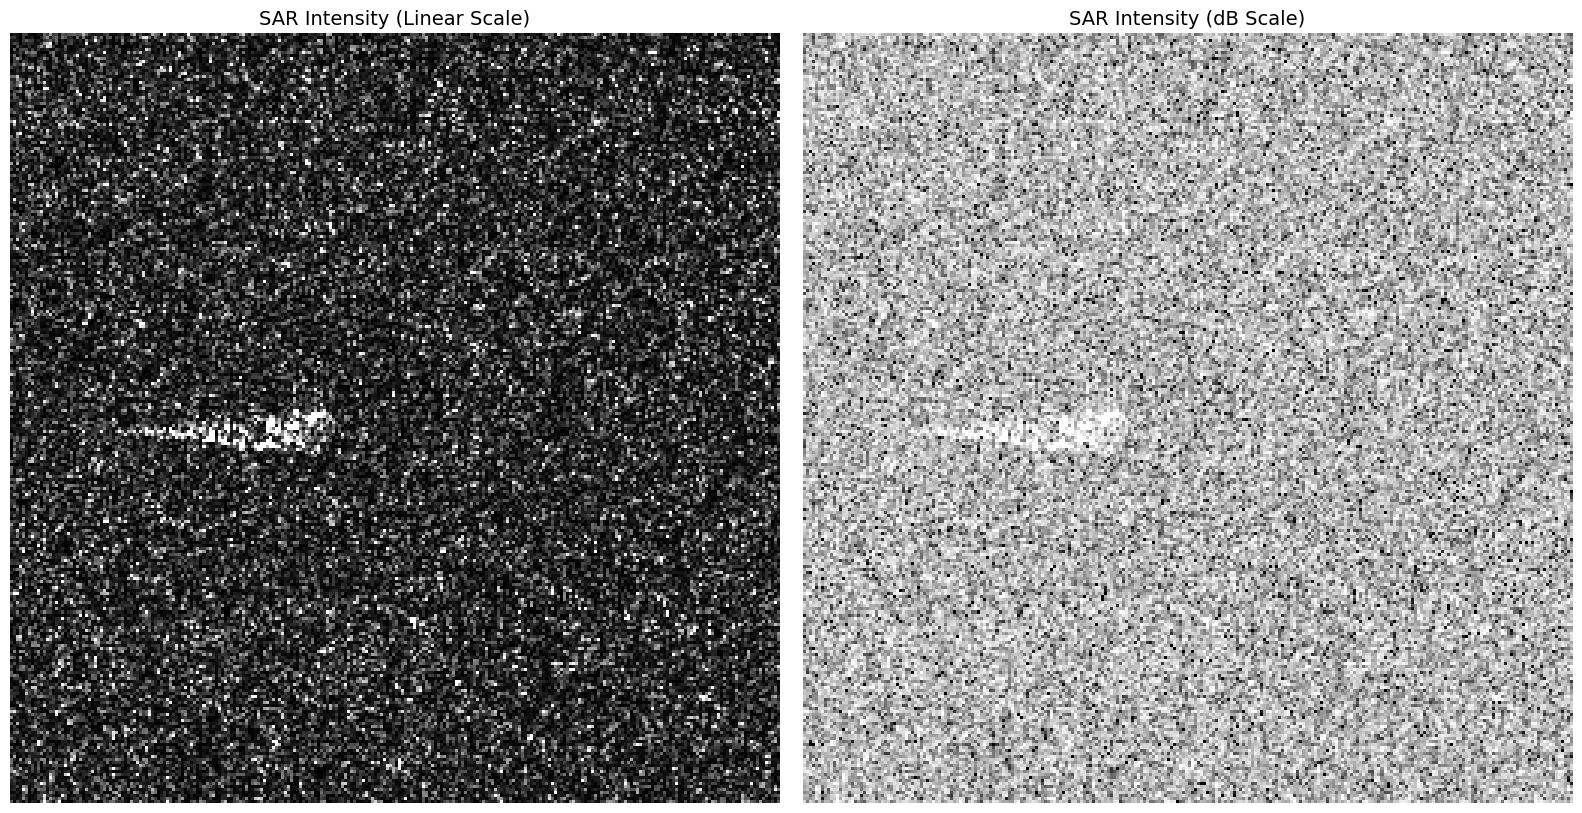

Computed detection threshold T: 1.4696


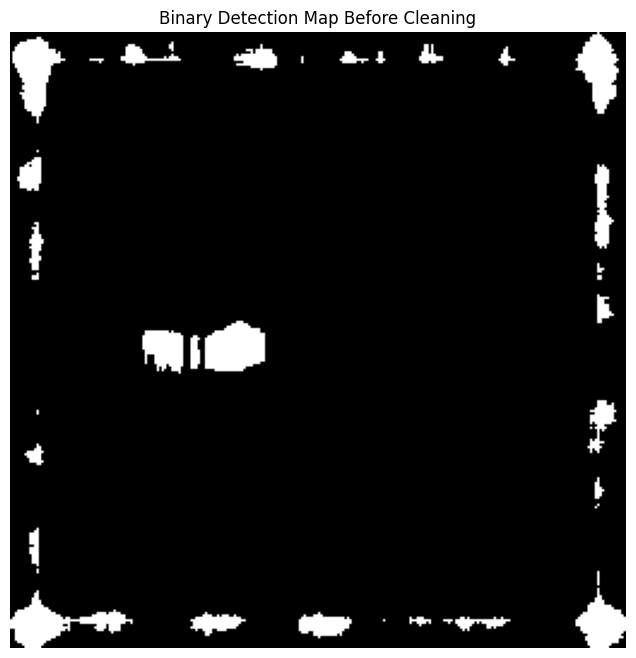

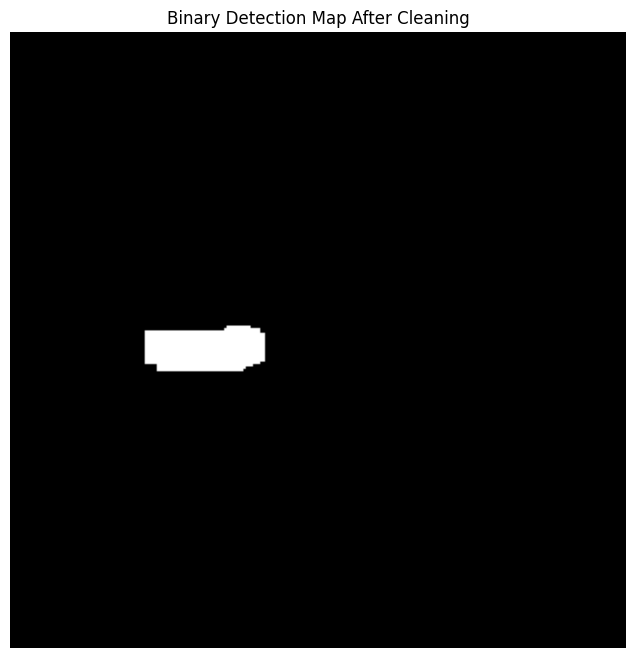

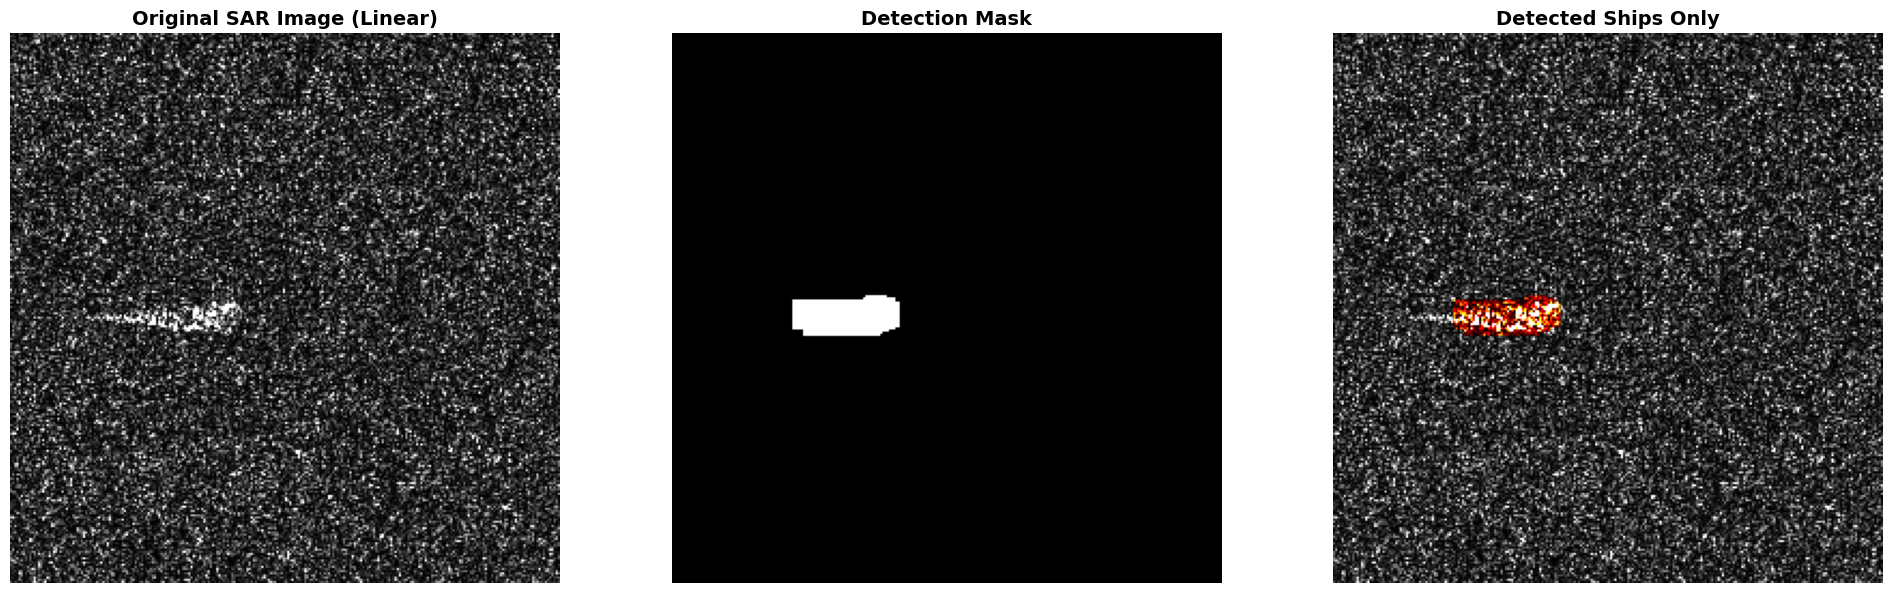

In [152]:
N1 = 11 # Test area, where we expect to find a ship 
# A ship might be larger than the area of 9 (3x3) pixels,
# but we will fill in the missing pixels at the end
N2 = 21 # Background reference area
paf = 10e-5  # Probability of false alarm

detected_ship = detection_algorithm(sar_roi, N1, N2, P_FA=paf)

We can notice that the ship was well detected, and none of the speckle was detected as a ship. Now if we use the same image with a bit larger region of interest, the situation would be a bit different.

ROI shape: (512, 512)
ROI dtype: complex64


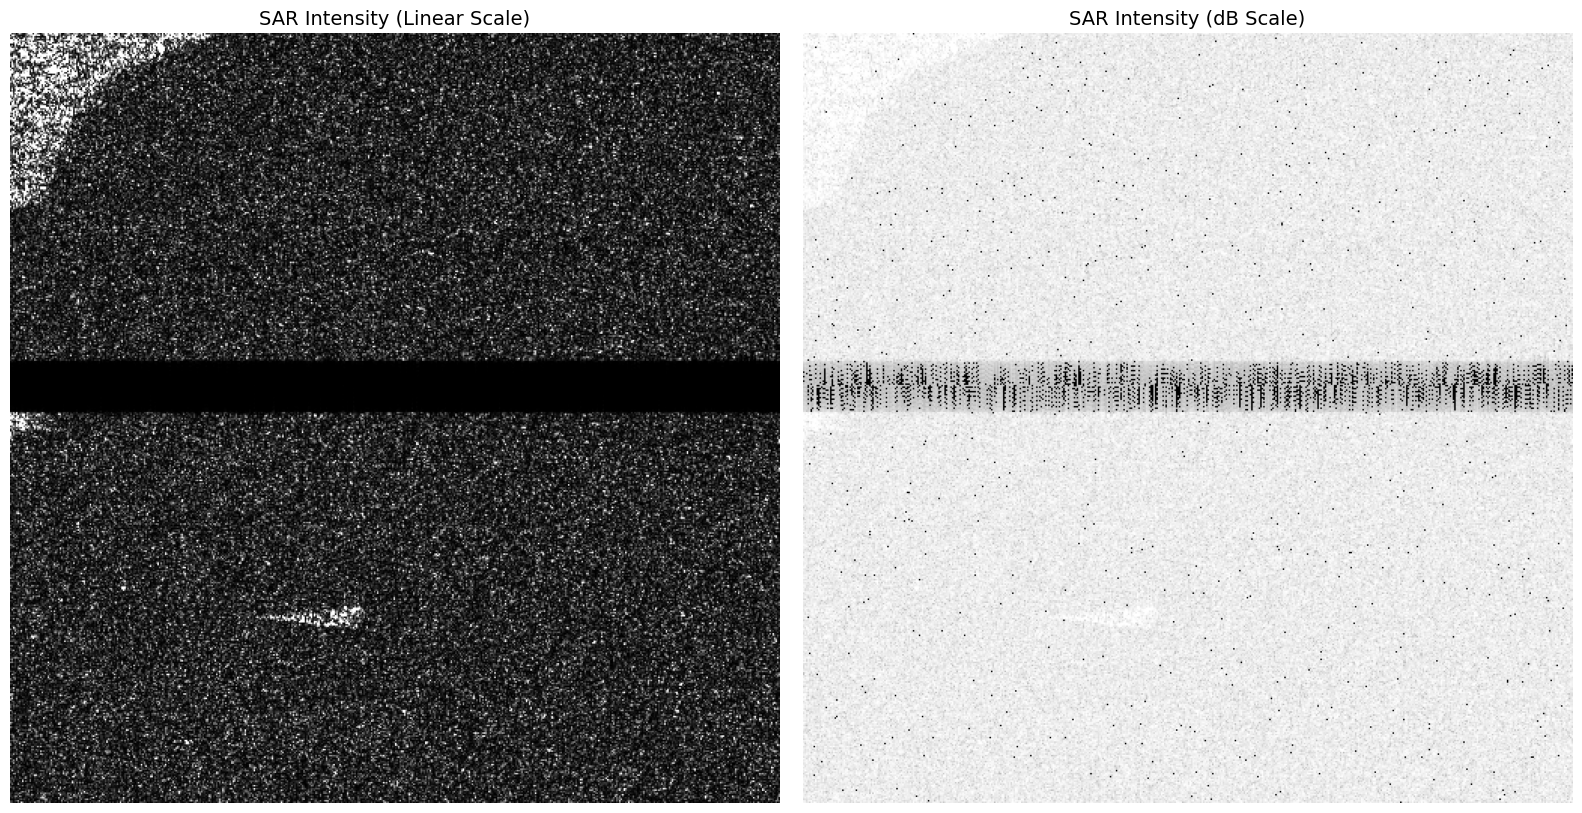

Computed detection threshold T: 1.4696


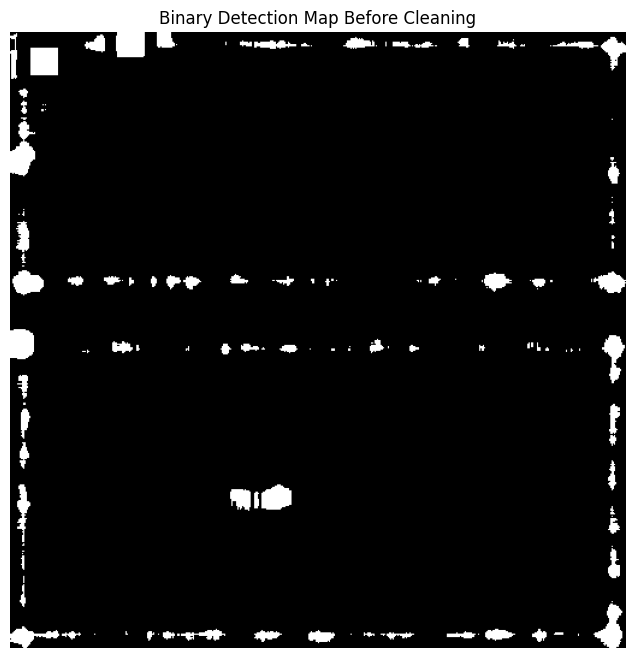

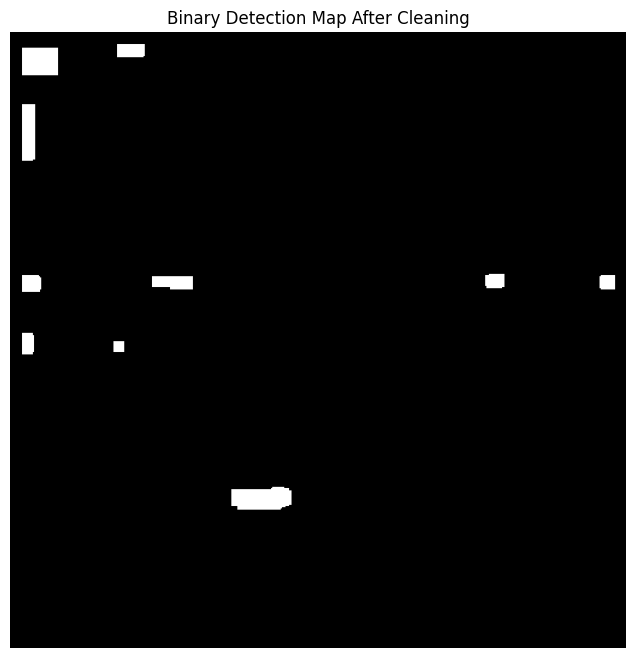

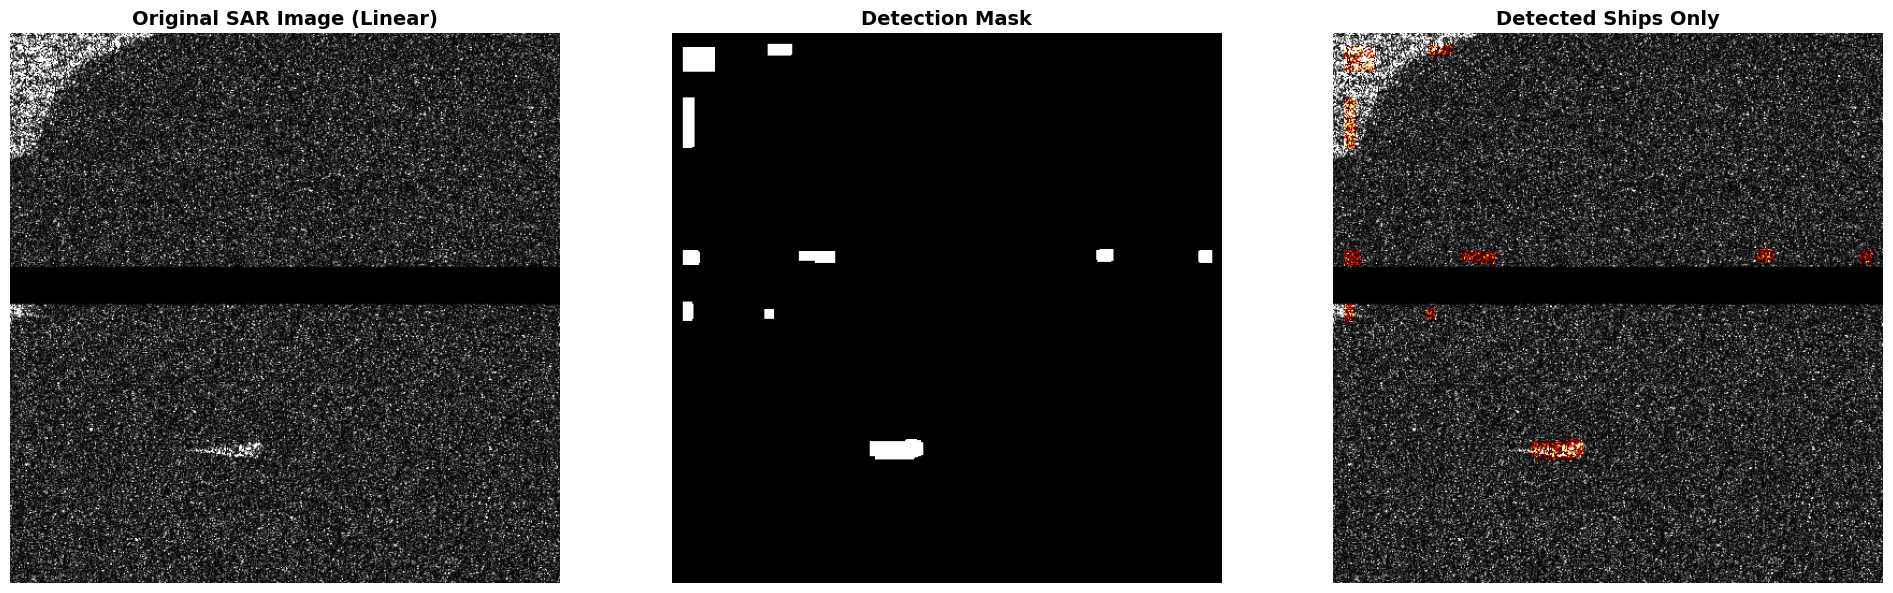

In [153]:
# Full image is too big to work with so we will use only part of it
roi_size = 512
center_x = complex_data.shape[1] // 2
center_y = complex_data.shape[0] // 2

start_x = center_x + roi_size
start_y = center_y + roi_size

sar_roi_larger = complex_data[start_y:start_y+roi_size, start_x:start_x+roi_size]


print(f"ROI shape: {sar_roi_larger.shape}")
print(f"ROI dtype: {sar_roi_larger.dtype}")
detected_ship_larger = detection_algorithm(sar_roi_larger, N1, N2, P_FA=paf)

In this case, the ship was still well detected; however, parts of the coast were also detected. Further, we can notice a dark stripe on the SAR image, which could be an area of low visibility due to the satellite incidence angle. Because of this dark region, speckle around it was also detected as ships. In this specific case, we could try to limit the size of the region and exclude some false detections.

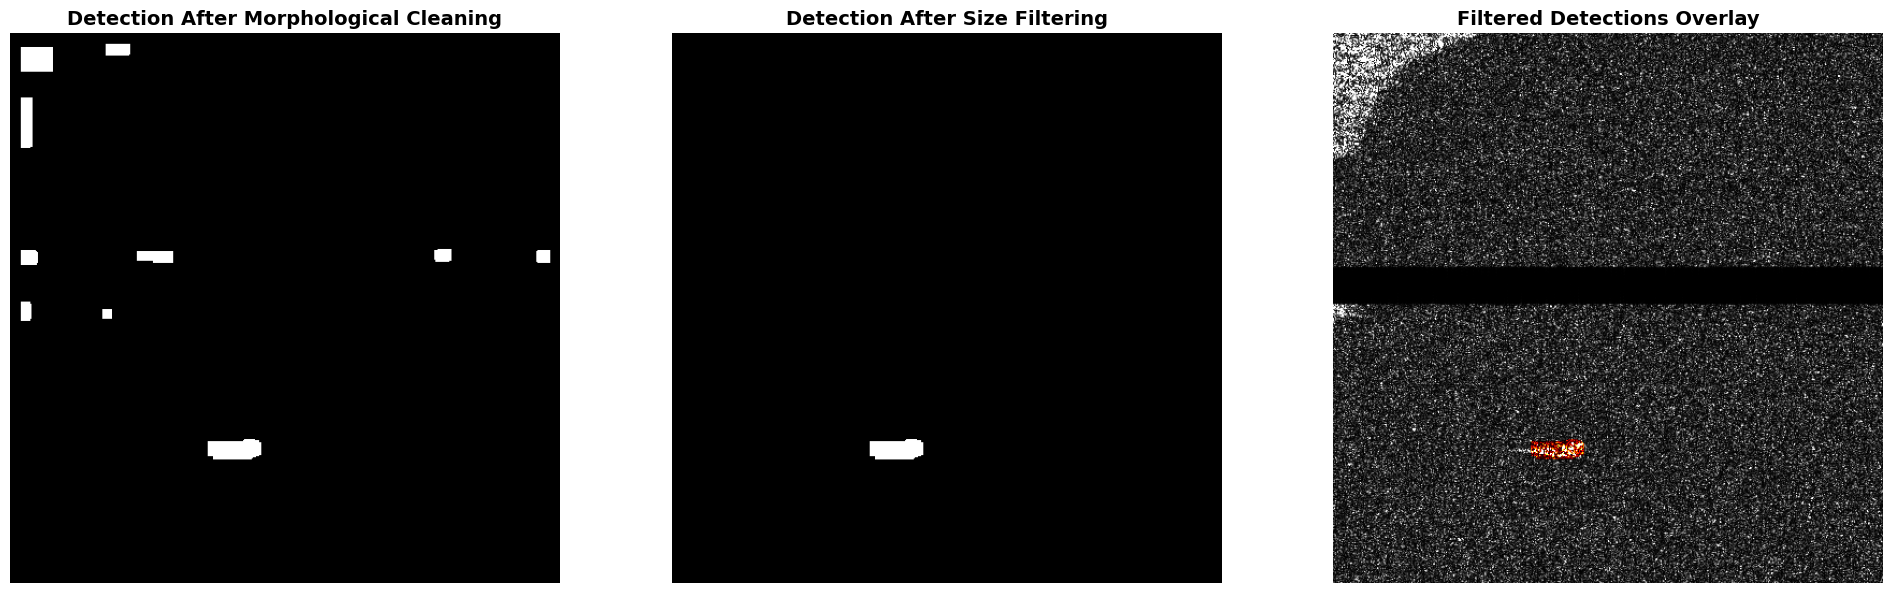

In [154]:
from scipy.ndimage import label

def size_filtering(binary_map, min_area=50, max_area=5000):
    labeled_map, num_features = label(binary_map)
    

    filtered_map = np.zeros_like(binary_map)
    
    regions_kept = 0
    for region_id in range(1, num_features + 1):
        region_mask = (labeled_map == region_id)
        region_area = np.sum(region_mask)
        
        if min_area <= region_area <= max_area:
            filtered_map[region_mask] = 1
            regions_kept += 1
    
    
    return filtered_map

filtered_detection = size_filtering(detected_ship_larger, min_area=700, max_area=2000)

intensity_larger = np.abs(sar_roi_larger)**2

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(detected_ship_larger, cmap='gray')
axes[0].set_title('Detection After Morphological Cleaning', fontsize=14, fontweight='bold')
axes[0].axis('off')


axes[1].imshow(filtered_detection, cmap='gray')
axes[1].set_title('Detection After Size Filtering', fontsize=14, fontweight='bold')
axes[1].axis('off')

masked_intensity_filtered = intensity_larger.copy()
masked_intensity_filtered[filtered_detection == 0] = np.nan

axes[2].imshow(intensity_larger, cmap='gray', vmin=np.percentile(intensity_larger, 1), 
            vmax=np.percentile(intensity_larger, 99))
axes[2].imshow(masked_intensity_filtered, cmap='hot', vmin=np.percentile(intensity_larger, 1), 
            vmax=np.percentile(intensity_larger, 99))
axes[2].set_title('Filtered Detections Overlay', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

We managed to extract only the boat, but the size limits had to be manually set, which is not automatic enough for any image. Now we will try to find other image regions with ships and use the detection algorithm on them.

In [168]:
selected_file = tiff_files[4] 
print(f"Loading: {os.path.basename(selected_file)}")

with rasterio.open(selected_file) as src:
    print(f"\nImage Info:")
    print(f"  Dimensions: {src.width} x {src.height}")
    print(f"  Data type: {src.dtypes[0]}")
    print(f"  Number of bands: {src.count}")
    print(f"  CRS: {src.crs}")
    

    complex_data = src.read(1)

Loading: s1a-iw3-slc-vh-20251115t002636-20251115t002701-061881-07bcc0-003.tiff

Image Info:
  Dimensions: 24565 x 13581
  Data type: complex_int16
  Number of bands: 1
  CRS: None


We again have to manually extract the region of interest, exclude the coast and extract only the part with ships. Next image contains two ships, has the same size as in the first case (256x256) and will be using the same detection parameters.

In [213]:
# Full image is too big to work with so we will use only part of it
roi_size = 256
center_x = complex_data.shape[1] // 2
center_y = complex_data.shape[0] // 2

start_x = center_x + roi_size*14 + roi_size//8
start_y = center_y + roi_size*13 + roi_size//4

sar_roi2 = complex_data[start_y:start_y+roi_size, start_x:start_x+roi_size]


print(f"ROI shape: {sar_roi2.shape}")
print(f"ROI dtype: {sar_roi2.dtype}")

ROI shape: (256, 256)
ROI dtype: complex64


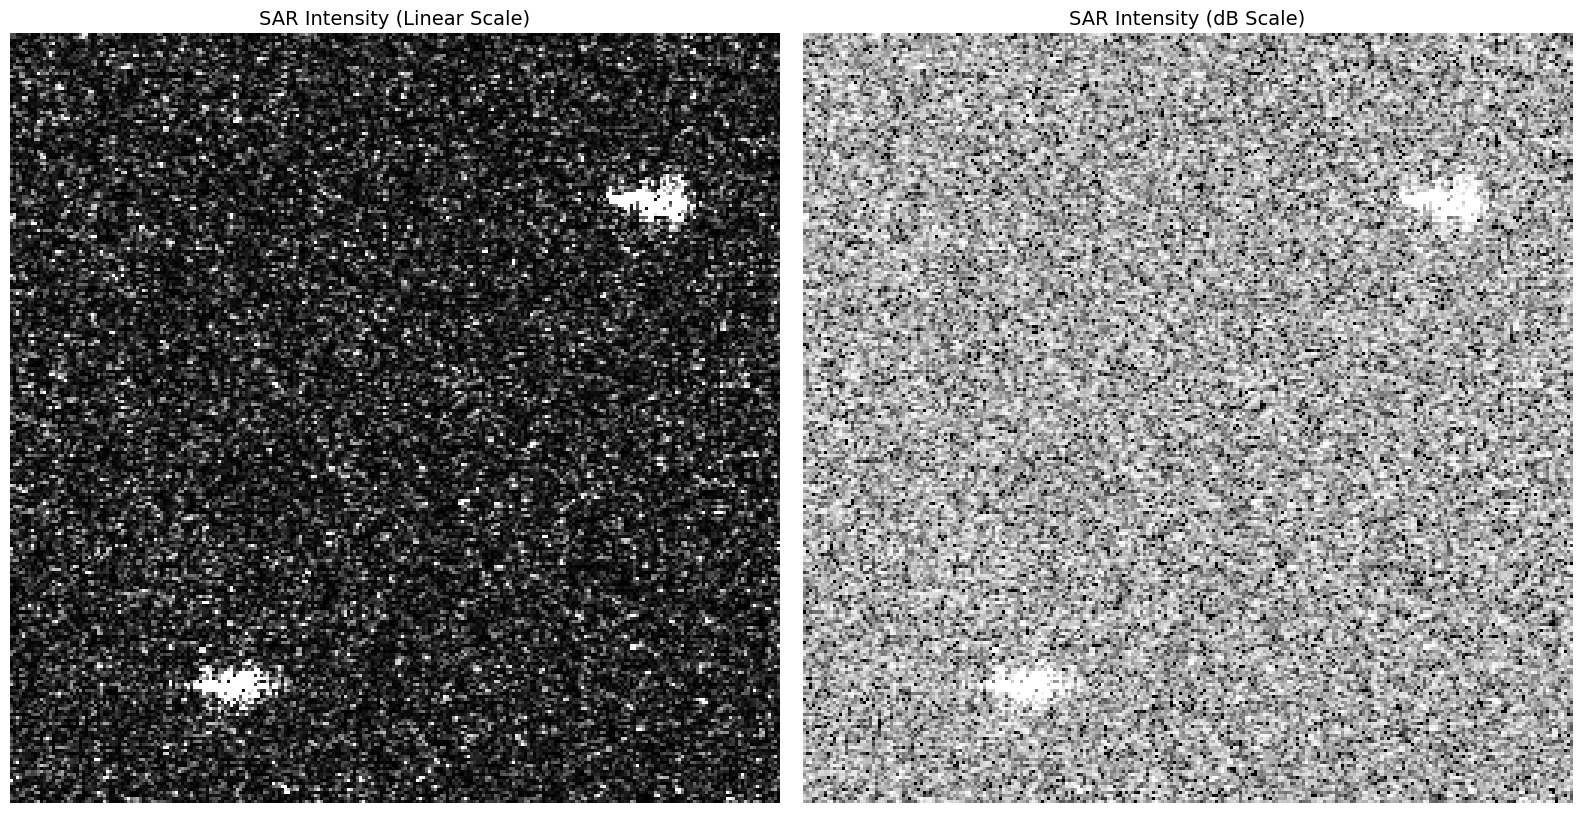

Computed detection threshold T: 1.4696


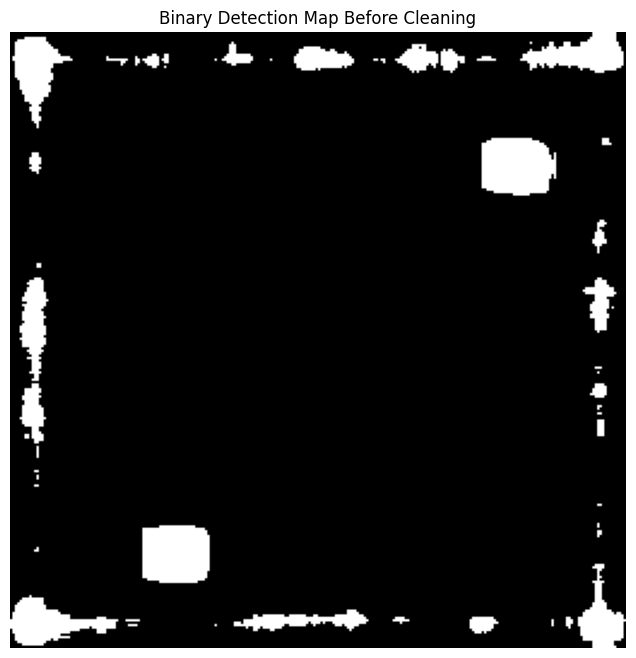

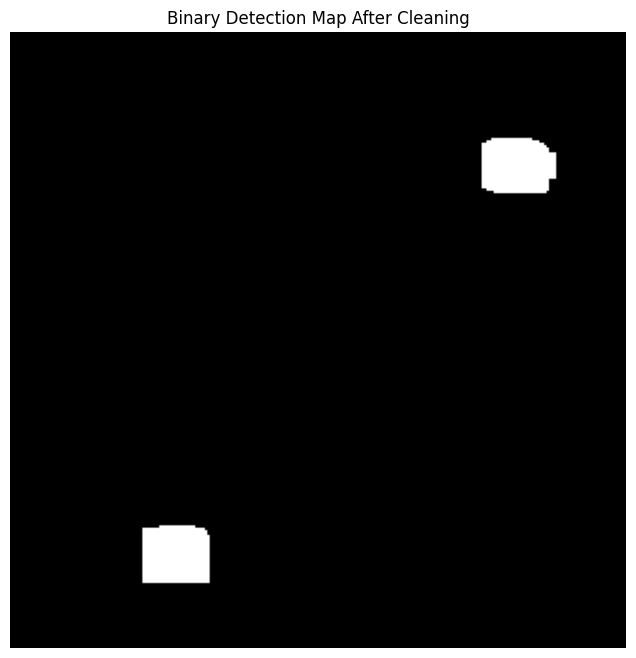

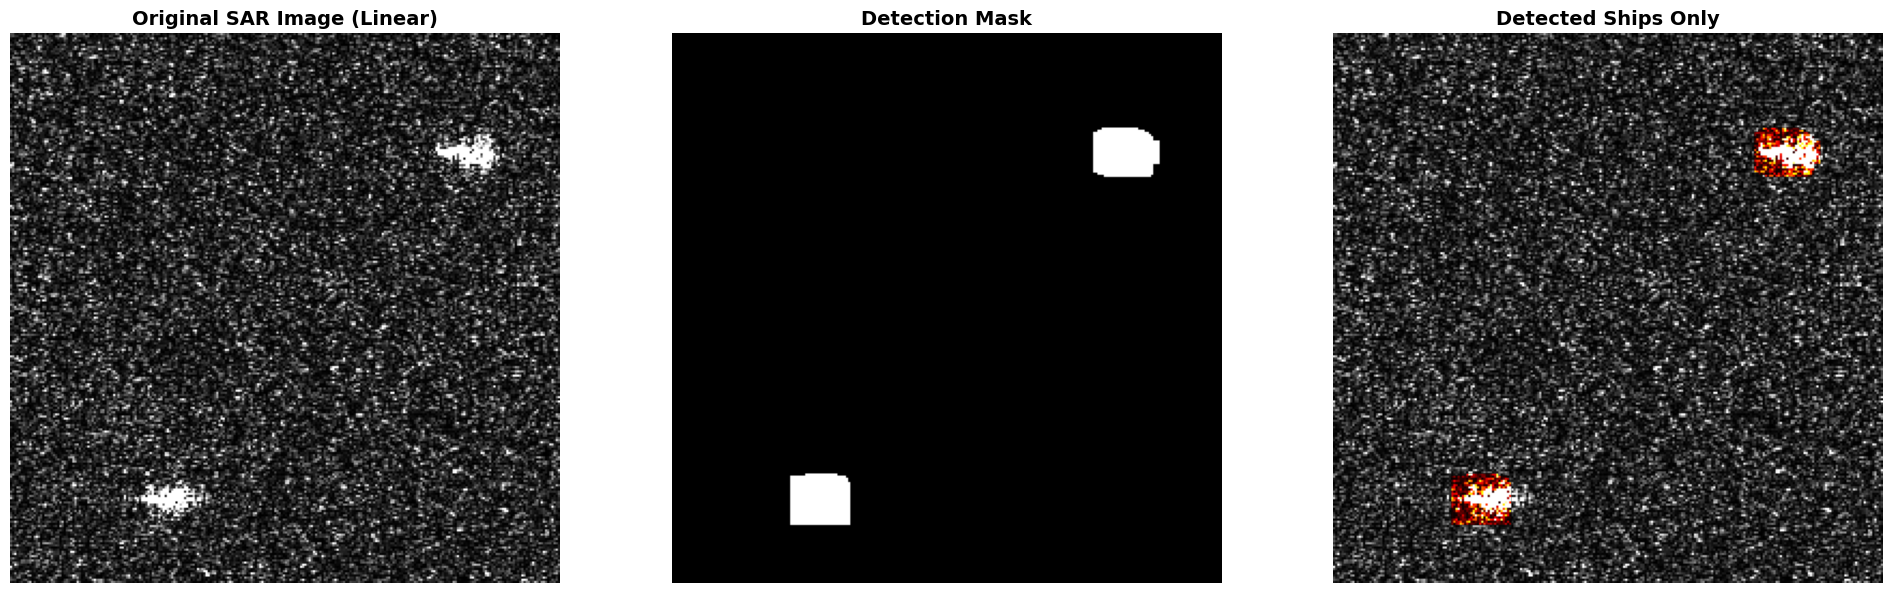

In [214]:
detected_ship2 = detection_algorithm(sar_roi2, N1, N2, P_FA=paf)

We can notice that in this case the ships were detected well again. We used the same set of parameters for detection as in the first case, which demonstrates that the target size $N_1 = 11$, window size $N_2=21$, and probability of false alarm $P_{FA}=10^{-5}$ work well for ROI sizes of 256×256 pixels. This consistency across different image regions suggests that these parameters are robust for ship detection in similar sea conditions.
